In [8]:
import gc

gc.collect()

import tensorflow  as tf
import tensorflow_hub as hub
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import keras
import tensorflow_text as text

In [9]:
model_path = "C:/Users/chuck/OneDrive/Desktop/Honors/models/Cell_classification/All_in_one/fine_tuned_model/"
loaded_model = tf.keras.models.load_model(model_path)


def write_numbers(image, prediction, truth):
    # Define the font and font scale
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5

    # Define the position and color for each number label
    positions = [(10, 20), (10, 50), (10, 90)]
    colors = [(0, 255, 0), (0, 0, 255), (255, 255, 0)]

    # Loop over each number and label, and write it onto the image
    for i, number in enumerate(prediction):
        label = f"{['good', 'crack', 'corrosion'][i]}: {number:.2f} ({truth[i]:.2f})"
        cv2.putText(image, label, positions[i], font, font_scale, (0,0,0), 2, cv2.LINE_AA)
        cv2.putText(image, label, positions[i], font, font_scale, colors[i], 1, cv2.LINE_AA)

    return image

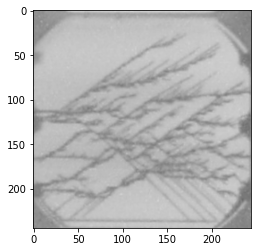

In [24]:
import cv2
image_path = "test_images/0_image_44.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image, (244,244))
plt.imshow(image)

In [25]:
loaded_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 1000)              768000    
                                                                 
 dense_1 (Dense)             (None, 3)                 3003      
                                                                 
Total params: 771,003
Trainable params: 3,003
Non-trainable params: 768,000
_________________________________________________________________


1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


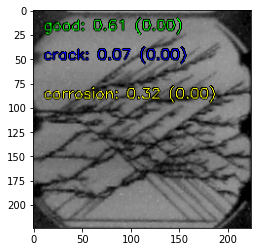

In [27]:
img = cv2.imread(image_path)
img = cv2.resize(img, (224, 224))  # resize to model input size
img_array = np.array(img)/128 - 1     # convert to numpy array

pred = loaded_model.predict(np.expand_dims(img_array, axis=0))[0]

image = write_numbers(img_array, pred, [0,0,0,0])
plt.imshow(image)

In [72]:
def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names, prediction_rank=1):
    # The variable "prediction_rank" is used to apply gradcam on the top class 
    # You can modify it to prediction_rank=n for a heatmap on the nth top class

    # First, we create a model that maps the input image to the activations of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # GradientTape() is a built-in Tensorflow tool to record operations for automatic differentiation.
        # https://www.tensorflow.org/api_docs/python/tf/GradientTape
        # We compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        # We pass the activations of the last conv in our classifier_model to obtain the predictions of the model
        preds = classifier_model(last_conv_layer_output)
        print(preds)
        # This prediction has a shape=(1, 1000) because there is 1000 classes in ImageNet. 
        # We find the index of the top prediction and we call it pred_index, because it's the index of the prediction 
        pred_index = tf.argsort(preds)[0][-prediction_rank]
        print(pred_index)
        # We only keep the value of the prediction at the position of the pred_index
        top_class_channel = preds[:, pred_index]
        print(preds[:, pred_index])


    # This is the gradient of the top predicted class with respect to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    print(grads)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    print(pooled_grads)

    # We multiply each channel in the feature map array
    # by "how important this channel is" with respect to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    grads = grads.numpy()
    
    last_conv_layer_output[:] *= tf.reshape(grads, (1,1000))
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of activation for the top class 
    # heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(last_conv_layer_output, 0) / np.max(last_conv_layer_output)
    return heatmap

last_conv_layer_name = "keras_layer_1"

classifier_layer_names = ["dense_1"]

heatmap = make_gradcam_heatmap(
    img_array, loaded_model, last_conv_layer_name, classifier_layer_names
)
print(heatmap.shape)

tf.Tensor([[0.4244568  0.00620473 0.5693385 ]], shape=(1, 3), dtype=float32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor([0.5693385], shape=(1,), dtype=float32)
tf.Tensor(
[[ 7.53522338e-03 -1.44147407e-03 -6.87417947e-03 -1.05054025e-02
  -4.12338488e-02  2.52071582e-02 -1.99910477e-02  8.41413811e-03
  -1.47004996e-03 -2.19400898e-02  2.25736257e-02 -1.72000453e-02
  -1.39172524e-02 -2.63289809e-02  2.61262991e-02 -3.02314274e-02
  -3.13509023e-03  5.68514504e-03  1.65982302e-02  2.62323171e-02
  -6.75424002e-04 -1.76844932e-02  5.07675903e-03  2.51713246e-02
   3.84822488e-04 -1.27350539e-03  1.86327938e-03 -2.68008169e-02
   3.79876196e-02 -3.00108716e-02 -1.24505386e-02 -9.28228814e-03
  -4.13571903e-03  1.28123099e-02  1.71723776e-02  1.67471857e-03
  -1.00522563e-02  2.79573239e-02  3.91525077e-03  4.86947410e-03
   1.29328314e-02  2.63917260e-03  2.32889503e-02  1.57600306e-02
   6.92638569e-03  1.64560620e-02  2.64598764e-02  2.32310779e-02
  -2.61274111e-02 -1.39778201e-03 

In [31]:
img_array = np.expand_dims(img_array, axis=0)

tf.Tensor([   1 1000], shape=(2,), dtype=int32)
-0.0
